# Figure Fixed cells HUVEC Feb 2024

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import os
import sys
sys.path.append("../") # needed to bring in sdc module
import sdc_config5 as sdc
import jax.numpy as jnp
import jax
# figures helper functions
%run figures_util.py


# Process and load ground truth spectra
Ground truth data acquired from vendor for the dyes

CellTrackerGreenCMFDA.csv
Viafluor488.csv
Qdot655.csv


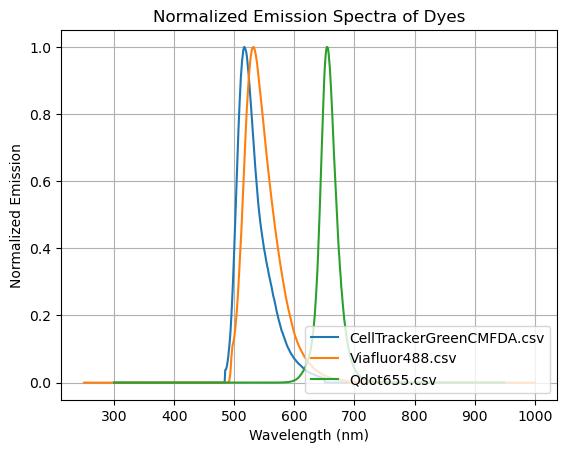

,Dye,Wavelengths,Emissions
0,CellTrackerGreenCMFDA.csv,"[300, 301, 302, 303, 304, 305, 306, 307, 308, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Viafluor488.csv,"[250, 251, 252, 253, 254, 255, 256, 257, 258, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Qdot655.csv,"[300, 301, 302, 303, 304, 305, 306, 307, 308, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [33]:
# Re-creating the combined_spectra_df (since it is not defined) and renaming it to gt_dyes_df

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the data folder
datafolder = '/home/neerja/DATA/SDCData/cell_dye_spectrum'

# Get the list of CSV files in the directory
files = os.listdir(datafolder)

# Initialize an empty list to store the data
combined_data = []

for f in files:
    if f.endswith('.csv'):  # Ensure only CSV files are processed
        print(f)
        
        # Read each CSV file into a pandas DataFrame
        file_path = os.path.join(datafolder, f)
        df = pd.read_csv(file_path)
        
        # Normalize the 'Emission' spectrum column (assuming it exists)
        df['Normalized Emission'] = df['Emission'] / np.max(df['Emission'])
        
        # Add a new row for each file, storing the wavelength and emission arrays
        combined_data.append({
            'Dye': f,  # The file name (dye) as identifier
            'Wavelengths': np.array(df['Wavelength']),  # Store all wavelengths as a NumPy array
            'Emissions': np.array(df['Normalized Emission'])  # Store all emissions as a NumPy array
        })
        
        # Plot each spectrum
        plt.plot(df['Wavelength'], df['Normalized Emission'], label=f)

# Convert the combined data list into a DataFrame
gt_dyes_df = pd.DataFrame(combined_data)

# Customize the plot
plt.title('Normalized Emission Spectra of Dyes')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Emission')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Display the renamed dataframe (gt_dyes_df) where each row represents a dye and contains the wavelength and emission arrays
gt_dyes_df


## System parameters

In [3]:
wvmin = 450
wvmax = 800
wvstep = 6
downsample_factor = 2
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)

mag_size = 10*9/39 # 10x followed by diffuser
spectral_camera_pixel_size = 2.4 # um
recon_pixel_size = spectral_camera_pixel_size*downsample_factor # 2x2 downsampling
gt_pixel_size = 4.4 # um #TODO: check this
gt_mag_size = 10*0.38 # 10x followed by 0.38x tube lens
superpixel_size = 160 # um


## Plot green cells

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].


Bead 1 - X: 291, Y: 512
Bead 2 - X: 398, Y: 456


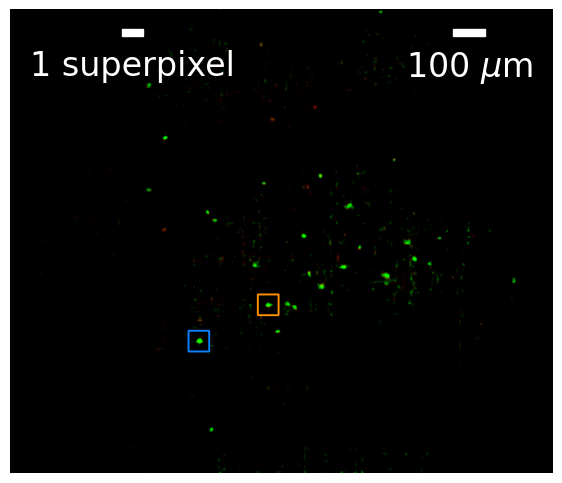

In [5]:
datafolder = '../Results/FOM2024'
file = 'huvec_celltrackergreen_10xmeas.tiff_thr=6e-05_xytv=1e-06_lamtv=2e-06_kmax=2000_stepsize=0.1_downsample=2.npy'

xk = np.load(os.path.join(datafolder, file))
HSI_data = np.transpose(xk, (1,2,0))
HSI_data = np.reshape(HSI_data, [-1,xk.shape[0]])
false_color = sdc.HSI2RGB(wavelengths, HSI_data ,xk.shape[1],xk.shape[2], 65, False)
skip =[]#  [0,1]#[0,3]

bead_locations, recon_annotated = findbeadsinimage(false_color, 50, skip = skip ,maxnum = 2, label_bead = False)

# Display the image with boxes and labels
fig, ax = plt.subplots(figsize=(7, 7))
scalebar = drawscalebar(ax,superpixel_size,recon_pixel_size)
plt.imshow(recon_annotated**1.8*2)
plt.axis('off')
ax.add_artist(scalebar)
scalebarum = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='100 $\mu$m', loc = 'upper right')
ax.add_artist(scalebarum)
# Print the bead locations
for i, (cx, cy) in enumerate(bead_locations):
    print(f"Bead {i+1} - X: {cx}, Y: {cy}")

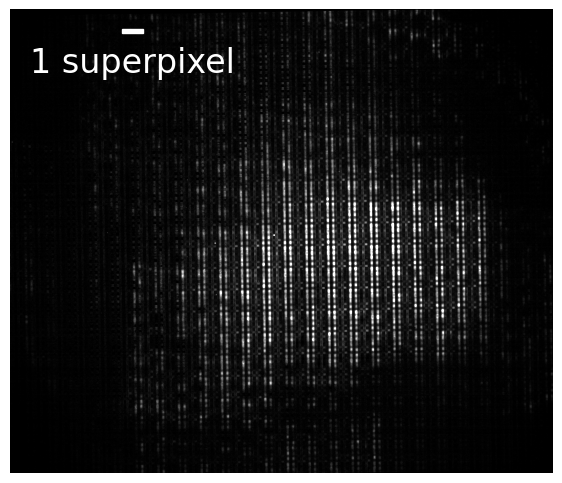

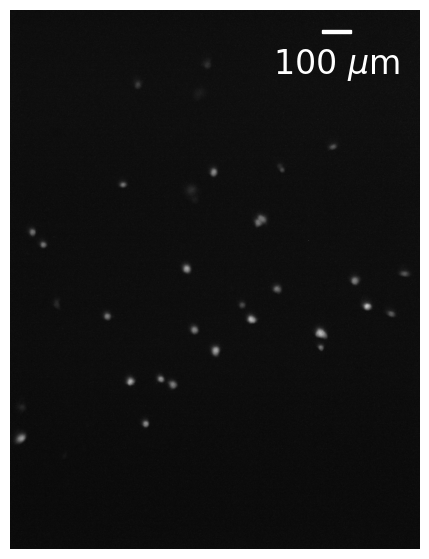

In [6]:
crop_indices = [420,1852,1150,2826] #top bottom left default: [320,1652,1350,2726]
datafolder = '/media/azuldata/neerja/2024-02-13_huvec/huvec_celltrackergreenorange_10x/'
meas_name = 'meas_8frame.tiff'
bg_name = 'bg.tiff'

bits = 16
power = 1
sample_meas = sdc.importTiff(datafolder,meas_name)/2**bits
try:
    background = sdc.importTiff(datafolder,bg_name)/2**bits
except:
    print('No background image found, continuing without background subtraction')
    background = torch.zeros(sample_meas.shape)
measurement = sdc.cropci((sample_meas-background),crop_indices).clip(0,1)**power

fig,ax = plt.subplots(figsize = (7,7))

plt.imshow(measurement, cmap='gray')
# plt.colorbar()  
plt.clim([0,.1])
plt.axis('off')

scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size)
ax.add_artist(scalebar)

# draw groundtruth
gt_name = 'gt.tiff'

# load sample and background both located in datafolder
gt = sdc.importTiff(datafolder,gt_name)/2**bits
gt = gt/torch.max(gt)

import scipy.ndimage as ndimage

# Rotate the image without zero-padding
gt_rot = ndimage.rotate(gt, -90, reshape=True)

fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(gt_rot,cmap='gray')
plt.axis('off')
scalebar = drawscalebar(ax, 100,gt_pixel_size,mag = gt_mag_size, scalebarname='100 $\mu$m', loc = 'upper right')
ax.add_artist(scalebar)


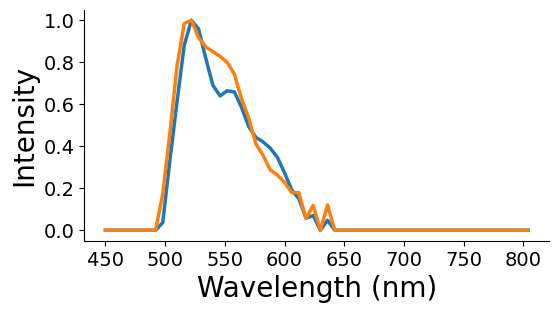

In [7]:
# plot the spectra
spectra = np.zeros((len(bead_locations), xk.shape[0]))
plt.figure(figsize=(6, 3))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, (cx, cy) in enumerate(bead_locations):
    spectra[i,:] = xk[:,cy,cx]/np.max(xk[:,cy,cx])
    plt.plot(wavelengths, spectra[i, :].T, color=colors[i], linewidth=2.5)

plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Intensity', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot(wavelengths_gt, spectra_gt[:,1],'k',linewidth=2.5)
# Turn off the box
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Plot Quantum Dot cells

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].


Bead 1 - X: 301, Y: 625
Bead 2 - X: 434, Y: 585
Bead 3 - X: 435, Y: 547
Bead 4 - X: 446, Y: 457
Bead 5 - X: 428, Y: 420
Bead 6 - X: 339, Y: 333
Bead 7 - X: 491, Y: 330
Bead 8 - X: 576, Y: 330
Bead 9 - X: 472, Y: 319
Bead 10 - X: 504, Y: 305


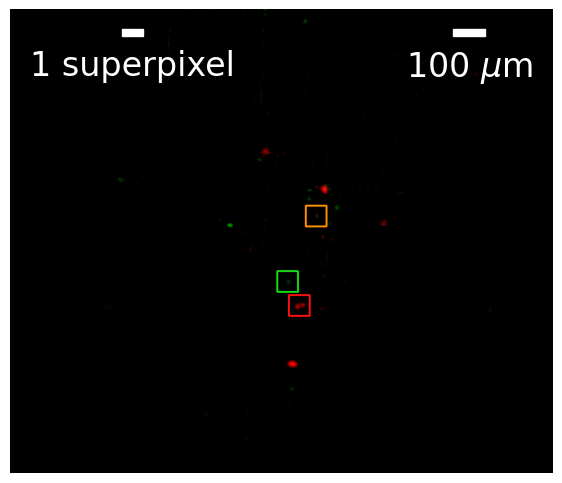

In [9]:
datafolder = '../Results/FOM2024'
file = 'huvec_greenred_10xmeas.tiff_thr=6e-05_xytv=1e-06_lamtv=2e-06_kmax=2000_stepsize=0.1_downsample=2.npy'

xk = np.load(os.path.join(datafolder, file))
HSI_data = np.transpose(xk, (1,2,0))
HSI_data = np.reshape(HSI_data, [-1,xk.shape[0]])
false_color = sdc.HSI2RGB(wavelengths, HSI_data ,xk.shape[1],xk.shape[2], 65, False)
skip = [0,1,2, 5, 6,7,9]#[0,3]
colindices = [3,2,1]

bead_locations, recon_annotated = findbeadsinimage(false_color, 20, skip = skip ,maxnum = 10, label_bead = False, colindices = colindices)

# Display the image with boxes and labels
fig, ax = plt.subplots(figsize=(7, 7))
scalebar = drawscalebar(ax,superpixel_size,recon_pixel_size)
plt.imshow(recon_annotated**1.8*2)
plt.axis('off')
ax.add_artist(scalebar)
scalebarum = drawscalebar(ax, 100, recon_pixel_size, mag = mag_size, scalebarname='100 $\mu$m', loc = 'upper right')
ax.add_artist(scalebarum)
# Print the bead locations
for i, (cx, cy) in enumerate(bead_locations):
    print(f"Bead {i+1} - X: {cx}, Y: {cy}")

(-0.5, 119.5, 249.5, -0.5)

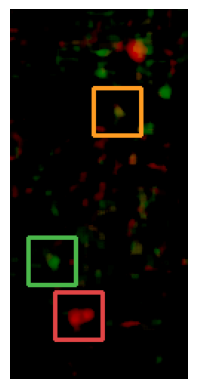

In [10]:
zoom = recon_annotated[250:500,400:520,:]
plt.imshow(zoom**.7)
plt.axis('off')

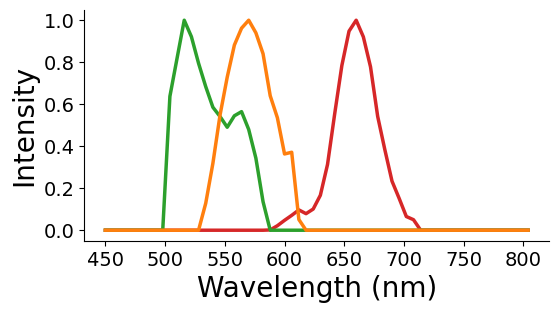

In [12]:
# plot the spectra
spectra = np.zeros((len(bead_locations), xk.shape[0]))
plt.figure(figsize=(6, 3))
colindex = 0
for i, (cx, cy) in enumerate(bead_locations):
    if i not in skip: #skip the first fake bead
        spectra[i,:] = xk[:,cy,cx]/np.max(xk[:,cy,cx])
        plt.plot(wavelengths, spectra[i, :].T, color=colors[colindices[colindex]], linewidth=2.5)
        colindex += 1

plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Intensity', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.plot(wavelengths_gt, spectra_gt[:,2],'k',linewidth=2.5)
# Turn off the box
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

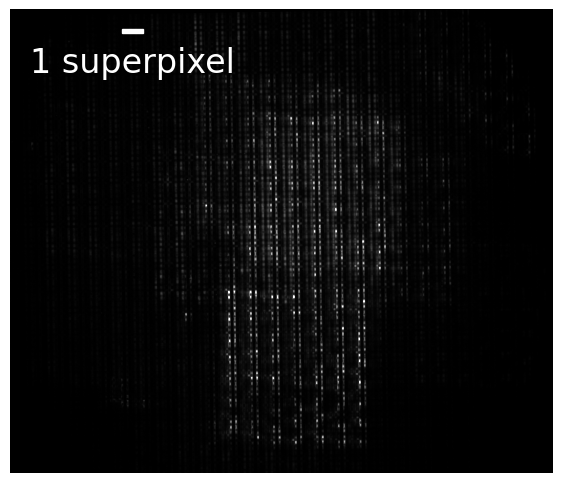

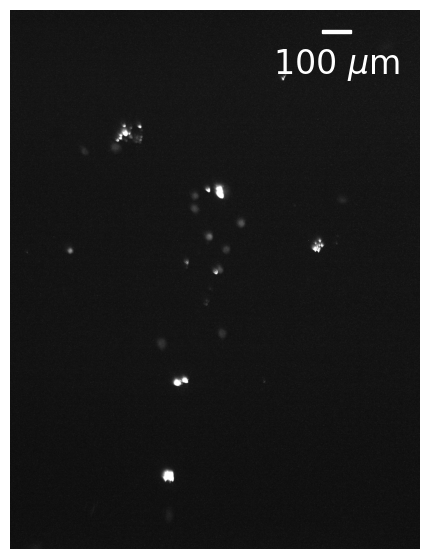

In [13]:
crop_indices = [420,1852,1150,2826] #top bottom left default: [320,1652,1350,2726]
datafolder = '/media/azuldata/neerja/2024-02-13_huvec/huvec_greenred_10x/'
meas_name = 'meas.tiff'
bg_name = 'bg.tiff'

bits = 16
power = 1
sample_meas = sdc.importTiff(datafolder,meas_name)/2**bits
try:
    background = sdc.importTiff(datafolder,bg_name)/2**bits
except:
    print('No background image found, continuing without background subtraction')
    background = torch.zeros(sample_meas.shape)
measurement = sdc.cropci((sample_meas-background),crop_indices).clip(0,1)**power

fig,ax = plt.subplots(figsize = (7,7))

plt.imshow(measurement, cmap='gray')
# plt.colorbar()  
plt.clim([0,.5])
plt.axis('off')

scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size)
ax.add_artist(scalebar)

# draw groundtruth
gt_name = 'gt.tiff'

# load sample and background both located in datafolder
gt = sdc.importTiff(datafolder,gt_name)/2**bits
gt = gt/torch.max(gt)

import scipy.ndimage as ndimage

# Rotate the image without zero-padding
gt_rot = ndimage.rotate(gt, -90, reshape=True)

fig,ax = plt.subplots(figsize = (7,7))
plt.imshow(gt_rot,cmap='gray')
plt.axis('off')
scalebar = drawscalebar(ax, 100,gt_pixel_size,mag = gt_mag_size, scalebarname='100 $\mu$m', loc = 'upper right')
ax.add_artist(scalebar)
